In [15]:
import pandas as pd
from ta.trend import SMAIndicator, MACD
from ta.momentum import RSIIndicator
import pynance as pn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
#loading the datas
file_paths = {
    'AAPL': '../data/AAPL_historical_data.csv',
    'GOOGL': '../data/AMZN_historical_data.csv',
    'AMZN': '../data/GOOG_historical_data.csv',
    'MSFT': '../data/META_historical_data.csv',
    'TSLA': '../data/MSFT_historical_data.csv',
    'META': '../data/NVDA_historical_data.csv',
    'NFLX': '../data/TSLA_historical_data.csv'
}

stock_data = {}

for company, path in file_paths.items():
    df = pd.read_csv(path, parse_dates=['Date'])
    df.set_index('Date', inplace=True) 
    stock_data[company] = df


In [17]:
#cleaning - drop any missing datasets
for name, df in stock_data.items():
    stock_data[name] = df.dropna()
    print(f"{name}: {stock_data[name].isnull().sum().sum()} missing values after dropping")


AAPL: 0 missing values after dropping
GOOGL: 0 missing values after dropping
AMZN: 0 missing values after dropping
MSFT: 0 missing values after dropping
TSLA: 0 missing values after dropping
META: 0 missing values after dropping
NFLX: 0 missing values after dropping


In [18]:
#technical indicators
def apply_technical_indicators(df, window_sma=20, window_rsi=14):
    df = df.copy()
    
    # SMA
    sma = SMAIndicator(close=df['Close'], window=window_sma)
    df['SMA'] = sma.sma_indicator()
    
    # RSI
    rsi = RSIIndicator(close=df['Close'], window=window_rsi)
    df['RSI'] = rsi.rsi()
    
    # MACD
    macd = MACD(close=df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_diff'] = macd.macd_diff()
    
    return df.dropna()

In [19]:
#apply for all companies
for company in stock_data:
    stock_data[company] = apply_technical_indicators(stock_data[company])

In [20]:
tickers = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA', 'META', 'NFLX']
stock_metrics = {}

for ticker in tickers:
    df = pn.data.get(ticker, start='2022-01-01', end='2023-01-01')
    daily_returns = df['Close'].pct_change()
    stock_metrics[ticker] = {
        'data': df,
        'daily_returns': daily_returns,
        'cumulative_returns': (1 + daily_returns).cumprod(),
        'volatility': daily_returns.std(),
        'rolling_mean': df['Close'].rolling(20).mean(),
        'rolling_std': df['Close'].rolling(20).std()
    }


In [21]:
#VISUALIZATION
#Line Plot of Stock Prices
plt.figure(figsize=(12, 6))
for name, df in stock_data.items():
    plt.plot(df.index, df['Close'], label=name)

plt.title("Stock Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

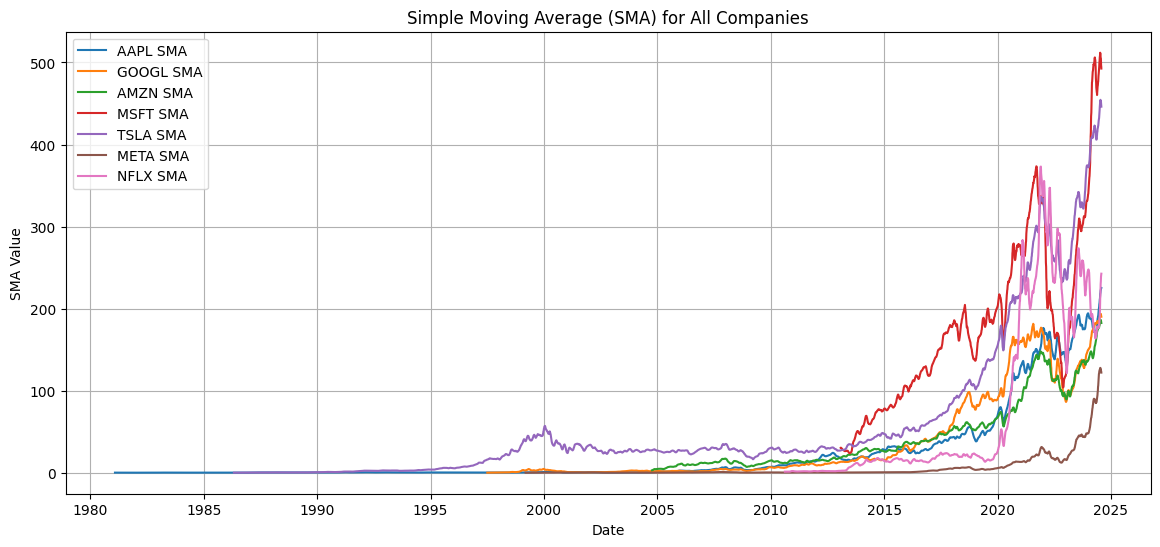

In [22]:
#Plot with SMA (Simple Moving Average)
plt.figure(figsize=(14, 6))
for name, df in stock_data.items():
    plt.plot(df.index, df['SMA'], label=f'{name} SMA')
plt.title('Simple Moving Average (SMA) for All Companies')
plt.xlabel('Date')
plt.ylabel('SMA Value')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
#RSI (Relative Strength Index) Plot
plt.figure(figsize=(14, 6))
for name, df in stock_data.items():
    plt.plot(df.index, df['RSI'], label=f'{name} RSI')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.title('RSI (Relative Strength Index) for All Companies')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()


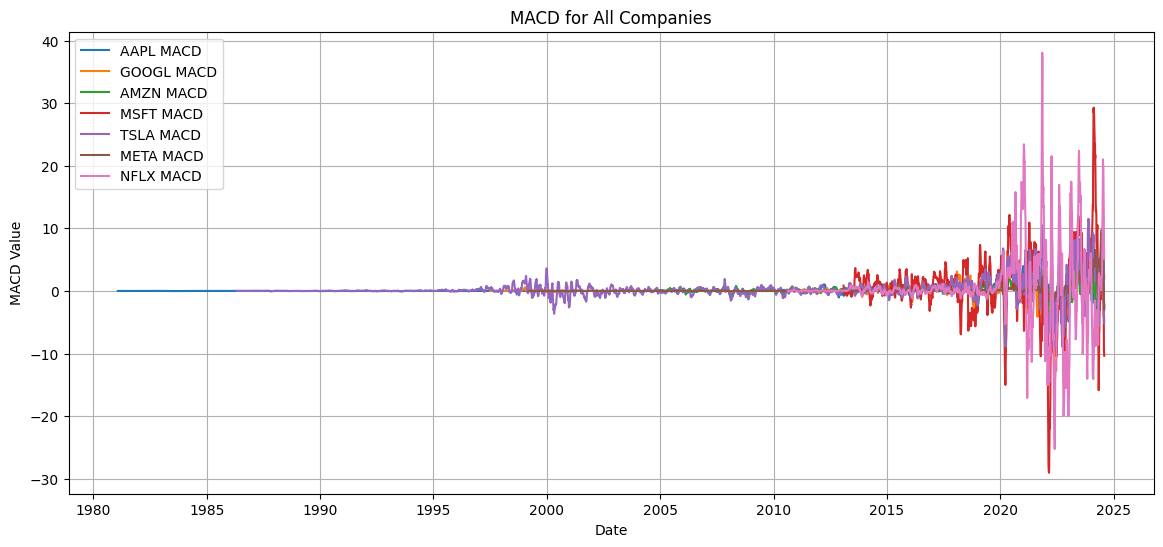

In [24]:
#MACD (Moving Average Convergence Divergence)
plt.figure(figsize=(14, 6))
for name, df in stock_data.items():
    plt.plot(df.index, df['MACD'], label=f'{name} MACD')
plt.title('MACD for All Companies')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()


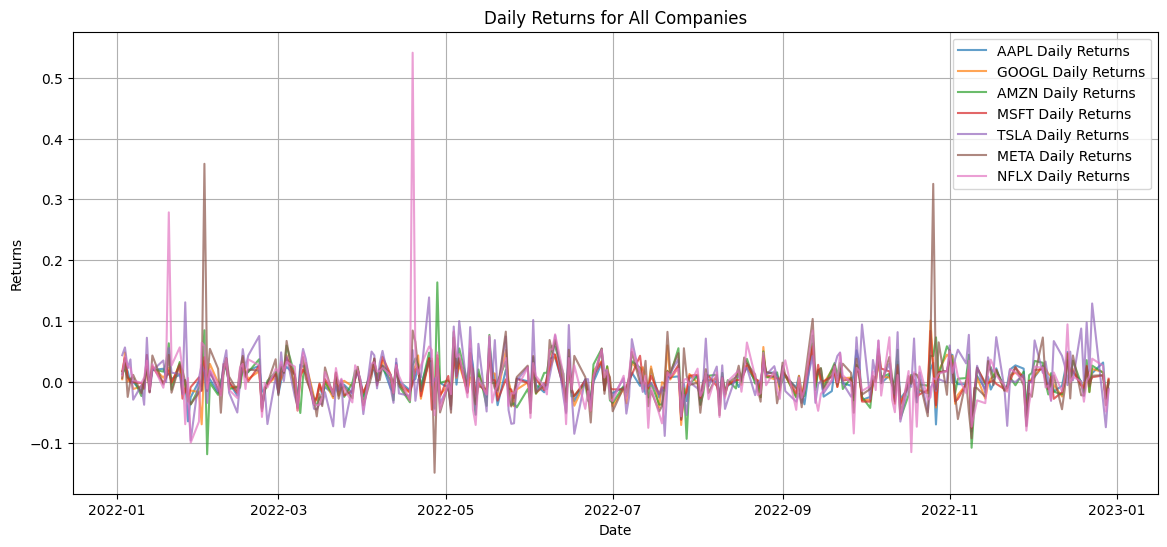

In [25]:
#Daily Returns for All Companies
plt.figure(figsize=(14, 6))
for ticker in tickers:
    plt.plot(stock_metrics[ticker]['daily_returns'].index, stock_metrics[ticker]['daily_returns'], label=f"{ticker} Daily Returns", alpha=0.7)
plt.title("Daily Returns for All Companies")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
news_df = pd.read_csv("../data/cleaned_analyst_ratings.csv", parse_dates=["date"])

In [27]:
#normalizing date formats
# Try conversion without 'format', and drop problematic rows
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Drop rows with NaT (invalid dates)
news_df = news_df.dropna(subset=['date'])

# Convert to just the date (if you only want the day)
news_df['date'] = news_df['date'].dt.date
for name in stock_data:
    stock_data[name].index = pd.to_datetime(stock_data[name].index).date


In [28]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Range: [-1, 1]

news_df['sentiment_score'] = news_df['headline'].astype(str).apply(get_sentiment)


In [29]:
for name, df in stock_data.items():
    df['Daily_Return'] = df['Close'].pct_change()

In [30]:
news_df['Sentiment'] = news_df['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [31]:
##sentiment analysis
daily_sentiment = news_df.groupby('date')['Sentiment'].mean()

In [33]:
#correlation between stock returns and sentiment
correlation_results = {}

for name, df in stock_data.items():
    temp_df = df.copy()
    temp_df = temp_df.dropna(subset=['Daily_Return'])

    # Properly extract date
    temp_df['date'] = pd.to_datetime(temp_df.index).map(lambda x: x.date())

    # Merge with daily sentiment
    merged = pd.merge(temp_df, daily_sentiment, left_on='date', right_on='date', how='inner')

    # Correlation between sentiment and stock return
    correlation = merged['Daily_Return'].corr(merged['Sentiment'])
    correlation_results[name] = correlation


In [34]:
for ticker, corr in correlation_results.items():
    print(f"{ticker}: Correlation between sentiment and daily return = {corr:.4f}")


AAPL: Correlation between sentiment and daily return = -0.0020
GOOGL: Correlation between sentiment and daily return = -0.0194
AMZN: Correlation between sentiment and daily return = 0.0143
MSFT: Correlation between sentiment and daily return = -0.0026
TSLA: Correlation between sentiment and daily return = -0.0128
META: Correlation between sentiment and daily return = 0.0093
NFLX: Correlation between sentiment and daily return = 0.0277
